dataset link : https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification?select=test

구글 이미지 검색을 통해 스크랩한 중복되지 않은 5917개의 '치와와'와 '머핀' 이진 이미지 분류 문제를 위한 데이터셋

training : 3786개 사용  
validation : 947개 사용  
test : 1184개 있음

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms

# Train

In [2]:
transform = transforms.Compose([transforms.Resize(255), # 이미지의 크기를 255 x 255 픽셀로 조정
                                transforms.CenterCrop(224), # 중앙의 224 x 224 픽셀만 잘라냄
                                transforms.ToTensor()]) # 이미지를 PyTorch 텐서로 변환 [0, 255] -> [0.0, 1.0]

data = datasets.ImageFolder("./data/chimuf/train",
                            transform = transform)

data_length = len(data) # 4733
training, validation = random_split(data,
                                    [int(0.8*data_length),
                                    data_length-int(0.8*data_length)]) # (3786, 947)

# len(data), len(training), len(validation)

In [3]:
data_loader = DataLoader(data,
                         batch_size = 32, # 각 미니배치에 포함될 이미지 개수
                         shuffle = True, # 매 epoch마다 샘플을 섞음
                         num_workers = 4) # 4개의 프로세스를 병렬 사용하여 속도를 향상

training_loader = DataLoader(training,
                             batch_size = 32,
                             shuffle = True,
                             num_workers = 4)

validation_loader = DataLoader(validation,
                               batch_size = 32,
                               shuffle = True,
                               num_workers = 4)

# data_loader, training_loader, validation_loader

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [5]:
resnet = models.resnet50(pretrained = True)
resnet.fc = nn.Linear(2048, 2) # 이진분류를 위해 최종단의 fc linear의 output 조정
resnet = resnet.to(device)
print(resnet)

C:\Users\DESKTOP\anaconda3\envs\cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DESKTOP\anaconda3\envs\cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 10):
    since = time.time()  # 훈련 시간 측정

    best_model_wts = copy.deepcopy(model.state_dict())  # 최적의 모델 가중치 저장
    best_acc = 0.0  # 가장 좋은 정확도 저장

    for epoch in range(num_epochs):  # epoch 수만큼 반복
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # 각 epoch에서 훈련과 검증 단계
        for phase in ['train', 'val'] :
            if phase == 'train' :
                model.train()  # 학습 모드
            else:
                model.eval()   # 평가(검증) 모드

            running_loss = 0.0  # epoch별 손실 계산
            running_corrects = 0  # epoch별 정확한 예측 수 계산

            # 데이터셋을 순회합니다.
            for inputs, labels in [training_loader, validation_loader][phase == 'val'] :
                inputs = inputs.to(device)  # input 데이터를 GPU로 이동
                labels = labels.to(device)  # label 데이터를 GPU로 이동

                optimizer.zero_grad()  # 옵티마이저의 그래디언트 초기화
                inputs.unsqueeze(0)   # 입력 데이터의 차원 조정

                # 순방향 전파, 그래디언트 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # 출력 계산
                    _, preds = torch.max(outputs, 1)  # 가장 높은 점수를 받은 클래스를 예측값으로 선택
                    loss = criterion(outputs, labels)  # 손실 함수를 사용하여 손실 계산

                    # 역방향 전파 및 최적화
                    if phase == 'train':
                        loss.backward()  # 손실에 대한 그래디언트 계산
                        optimizer.step()  # 옵티마이저를 사용하여 모델의 가중치 업데이트

                # 통계를 계산합니다.
                running_loss += loss.item() * inputs.size(0)  # 현재 배치의 손실 누적
                running_corrects += torch.sum(preds == labels.data)  # 정확한 예측 수 누적
                
            if phase == 'train':
                scheduler.step()  # 학습률 스케줄러

            # epoch별 손실과 정확도 계산
            epoch_loss = running_loss / [int(0.8*data_length), data_length-int(0.8*data_length)][phase == 'val']
            epoch_acc = running_corrects.double() / [int(0.8*data_length), data_length-int(0.8*data_length)][phase == 'val']

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 검증 단계에서 최고의 정확도를 달성한 경우, 모델의 상태를 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 좋은 성능의 모델을 return
    model.load_state_dict(best_model_wts)
    return model

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr = 0.001, momentum = 0.9)
# optimizer = optim.Adam(resnet.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)

In [8]:
model_ft = train_model(resnet, criterion, optimizer, scheduler, num_epochs = 10)

Epoch 1/10
--------------------
train Loss: 0.0916 Acc: 0.9712
val Loss: 0.0251 Acc: 0.9916

Epoch 2/10
--------------------
train Loss: 0.0239 Acc: 0.9926
val Loss: 0.0165 Acc: 0.9947

Epoch 3/10
--------------------
train Loss: 0.0122 Acc: 0.9976
val Loss: 0.0153 Acc: 0.9947

Epoch 4/10
--------------------
train Loss: 0.0085 Acc: 0.9987
val Loss: 0.0134 Acc: 0.9958

Epoch 5/10
--------------------
train Loss: 0.0064 Acc: 0.9989
val Loss: 0.0145 Acc: 0.9958

Epoch 6/10
--------------------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.0137 Acc: 0.9958

Epoch 7/10
--------------------
train Loss: 0.0030 Acc: 0.9997
val Loss: 0.0156 Acc: 0.9947

Epoch 8/10
--------------------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.0138 Acc: 0.9958

Epoch 9/10
--------------------
train Loss: 0.0021 Acc: 0.9995
val Loss: 0.0147 Acc: 0.9958

Epoch 10/10
--------------------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.0145 Acc: 0.9958

Training complete in 4m 57s
Best val Acc: 1.000000


In [9]:
torch.save(model_ft.state_dict(), 'trained_model.pth')

# Test

In [10]:
model = models.resnet50(pretrained = False)
model.fc = nn.Linear(2048, 2)
model.load_state_dict(torch.load('trained_model.pth'))
model = model.to(device)

C:\Users\DESKTOP\anaconda3\envs\cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# 테스트 데이터셋 로드 및 전처리
test_data = datasets.ImageFolder("./data/chimuf/test",
                                 transform = transform)

# DataLoader 설정
test_loader = DataLoader(test_data,
                         batch_size = 32,
                         shuffle = False,
                         num_workers = 4)

In [12]:
model.eval()  # 모델을 평가 모드로 설정
test_loss = 0
correct = 0

with torch.no_grad() :
    for inputs, labels in test_loader :
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 99.83%


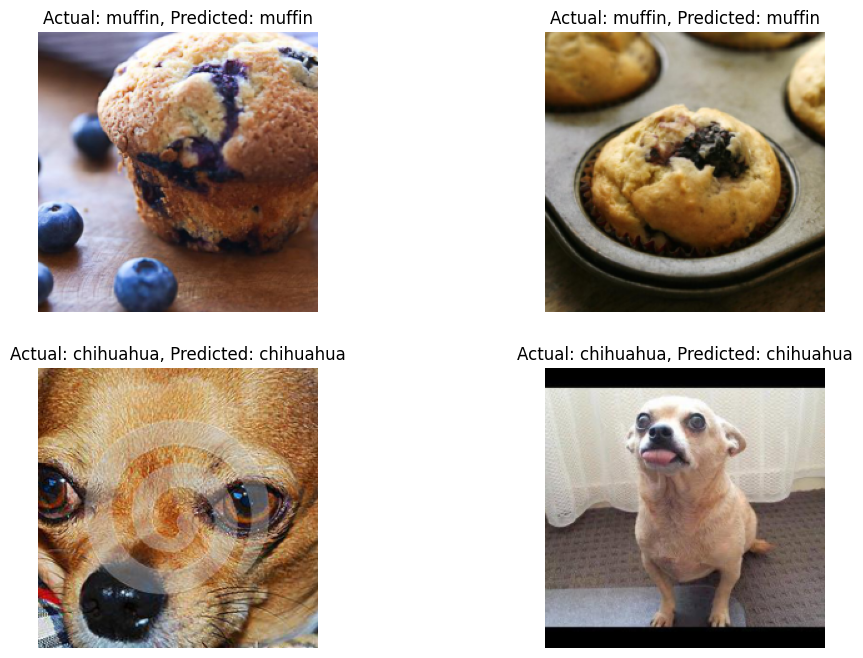

In [13]:
# 시각화할 이미지의 수 설정
num_images_to_display = 4

# 테스트 데이터셋에서 무작위 이미지 선택
selected_indices = random.sample(range(len(test_data)), num_images_to_display)

# 클래스 레이블 목록 정의
class_labels = ['chihuahua', 'muffin']

# 이미지와 예측 표시
plt.figure(figsize = (12, 8))

for idx, image_index in enumerate(selected_indices, 1) :
    image, label = test_data[image_index]

    with torch.no_grad() :
        image = image.unsqueeze(0).to(device)
        prediction = model(image)
        predicted_class = prediction.argmax().item()

    plt.subplot(2, num_images_to_display // 2, idx)
    plt.imshow(image.squeeze(0).cpu().permute(1, 2, 0))
    plt.title(f'Actual: {class_labels[label]}, Predicted: {class_labels[predicted_class]}')
    plt.axis('off')

plt.show()